<span style="font-size:24px; font-family:'Arial Bold'; color:darkblue;">
Supervisor overseeing two agents for free energy calculations and phase-field simulation
</span>

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain.schema import AIMessage
from langgraph_supervisor import create_supervisor


In [2]:
# Definition of tools
@tool
def Fe_Cr_gibbs_energy(temp1: float, comp1: float) -> float:
    """
    As for Fe-Cr binary alloy, receive float type temperature and float type alloy composition 
    as input parameters, and return the calculated float type Gibbs energy in J/mol.

    Args:
        temp1 (float): temperature, with a float type input parameter, unit is K.
        comp1 (float): alloy composition, with a float type input parameter, atomic fraction of Cr.
    Returns:
        Gc (float):Gibbs energy calculation result, with a float type, unit is J/mol
    """
    T=temp1; c=comp1

    RR = 8.3145 # Gas constant [J／（mol K）]    
    p_mag=0.4; D_mag=518./1125.+11692./15975.*(1./p_mag-1.)

    c1=1.-c; c2=c
    L0_FeCr=20500.0-9.68*T
    gc1=L0_FeCr*c1*c2+RR*T*(c1*np.log(c1)+c2*np.log(c2))
    # We set Gc_Fe_bcc=Gc_Cr_bcc=0. 
        
    Tc=1043.*c1-311.5*c2+c1*c2*(1650.-550.*(c1-c2))
    if Tc<0.: Tc=-Tc
    Bc=2.22*c1-0.008*c2-0.85*c1*c2
    if Bc<0.: Bc=-Bc

    tau=T/Tc
    if tau<=1.:
        ftau=1.-1./D_mag*(79./140./p_mag/tau+474./497.*(1./p_mag-1.)*( np.power(tau,3.)/6.+np.power(tau,9.)/135.+np.power(tau,15.)/600.) )
    else:
        ftau=-1./D_mag*(np.power(tau,-5.)/10.+np.power(tau,-15.)/315.+np.power(tau,-25.)/1500.)
 
    gmag=RR*T*np.log(1.+Bc)*ftau
    Gc=gc1+gmag
    return Gc

In [3]:
# Definition of tools
@tool
def Fe_C_gibbs_energy(temp1: float, comp1: float) -> float:
    """
    As for Fe-C binary alloy, receive float type temperature and float type alloy composition 
    as input parameters, and return the calculated float type Gibbs energy in J/mol.

    Args:
        temp1 (float): temperature, with a float type input parameter, unit is K.
        comp1 (float): alloy composition, with a float type input parameter, atomic fraction of C.
    Returns:
        Gc (float):Gibbs energy calculation result, with a float type, unit is J/mol
    """
    T=temp1; c=comp1

    RR = 8.3145 # Gas constant [J／（mol K）]    
    p_mag=0.4; D_mag=518./1125.+11692./15975.*(1./p_mag-1.)

    GHserCC=-17368.441+170.73*T-24.3*T*np.log(T)-4.723e-04*T*T+2562600./T-2.643e+08/T/T+1.2e+10/T/T/T
    GHserFe=1225.7+124.134*T-23.5143*T*np.log(T)-.00439752*T*T-5.8927e-08*T*T*T+77359./T
    GBccFe_Va=GHserFe
    GBccFe_C=322050.+75.667*T+GHserFe+3.*GHserCC
    LFe_CVa_0=-190.*T
    
    BMBccFe_C=2.22;  BMBccFe_Va=2.22
    TCBccFe_C=1043.; TCBccFe_Va=1043.
    
    yC=1./3.*c/(1.-c);	yVa=1.-yC
    
    Tc=yVa*TCBccFe_Va+yC*TCBccFe_C
    Bc=yVa*BMBccFe_Va+yC*BMBccFe_C
    
    tau=T/Tc
    if tau<=1.:
        ftau=1.-1./D_mag*(79./140./p_mag/tau+474./497.*(1./p_mag-1.)*( np.power(tau,3.)/6.+np.power(tau,9.)/135.+np.power(tau,15.)/600.))
    else:
        ftau=-1./D_mag*(np.power(tau,-5.)/10.+np.power(tau,-15.)/315.+np.power(tau,-25.)/1500.)
        
    gmag=RR*T*np.log(Bc+1.)*ftau
    
    Gc_bcc=yVa*GBccFe_Va+yC*GBccFe_C+yVa*yC*LFe_CVa_0+3.*RR*T*(yVa*np.log(yVa)+yC*np.log(yC))+gmag
    Gc=Gc_bcc/(1.+3.*yC)
    return Gc
    

In [4]:
# Definition of tool
@tool
def Fe_Cr_phase_field_simulation(aging_temp1: float, alloy_comp1: float)-> int:
    """
    Performs a phase-field simulation of Fe-Cr alloy during isothermal aging.
    It receives float type two input parameters: a temperature with the unit K, and an alloy composition of atomic fraction of Cr. 
    The phase-field simulation is performed, and the calculation results (numerical information of the composition field 
    and a two-dimensional microstructure image) are saved on hard-disk drive. 
    Finally, it returns the end status of the calculation as an int type. When the value of the end status is 0, the calculation fails, 
    and when the value of the end status is 1, the calculation succeeds.

    Args:
        temp1 (float): temperature, with a float type input parameter, unit is K.
        comp1 (float): alloy composition, with a float type input parameter, atomic fraction of Cr.

    Returns:
        iflg (int): end status of the calculation.
    """

    temp=aging_temp1;  c0=alloy_comp1

    PI = 3.141592 #π
    RR = 8.3145 #Gas constant [J／（mol K）]
    delt = 0.02 #time increment [dimensionless]
    iflg=0    

    #Setting materials and process constants
    ND = 128  #Dividing number in the difference method

    #c0 = 0.5 #Alloy composition （moll fraction of Cr）
    al = 60.0*1.e-9 #Side length of 2-dimensional simulation area [m]
    b1 = al/ND #1 block size in the difference method [m]

    #temp = 673.0 #Aging temperature [K]
    Rtemp = RR*temp # ＲＴ [J/mol]

    itime1 = 0 #Initial time (This is not a real time but an increment number）
    itime1max = 5000 + 1 #Time to stop the simulation(This is not a real time but an increment number）

    L0_0=20500.0 #Interaction parameter [J/mol]
    L0_1=-9.68 #L=L0_0+L0_1*T
    L0=(L0_0+L0_1*temp)/Rtemp #Normalized using RT

    kappa = 2.0e-15/b1** 2/Rtemp #Composition gradient energy coefficient, Normalized b1 and RT[Jm^2/mol]/b1^2/RT]

    a01=0.28664e-9 #Lattice constant (bcc Fe) [m]
    atomNo=2.0 #Atom number in unit cell
    vm0=6.02e23*a01*a01*a01/atomNo #Molar volume [m^3/mol]

    eta=0.00614 #格Lattice mismatch

    c11a=2.3310e+11 #Elastic constant of bcc-Fe [Pa]
    c12a=1.3544e+11
    c44a=1.1783e+11

    c11b=3.500e+11 #Elastic constant of bcc-Cr [Pa]
    c12b=0.678e+11
    c44b=1.008e+11

    c11a=c11a*vm0/Rtemp #Normalized using RT
    c12a=c12a*vm0/Rtemp
    c44a=c44a*vm0/Rtemp
    c11b=c11b*vm0/Rtemp
    c12b=c12b*vm0/Rtemp
    c44b=c44b*vm0/Rtemp

    c11=(1.0-c0)*c11a+c0*c11b #Elastic constant of alloy
    c12=(1.0-c0)*c12a+c0*c12b
    c44=(1.0-c0)*c44a+c0*c44b
    y100=c11+c12-2.0*(c12*c12/c11) #Elastic function Y<100>

    TcFe=1043.0 #Coefficients of Curie temperature
    TcCr=-311.5
    TcCrFe0=1650.0
    TcCrFe1=550.0

    BcFe=2.22 #Coefficients of Bohr magneton
    BcCr=-0.008
    BcCrFe0=-0.85

    p_mag=0.4 #(bcc)
    D_mag=518.0/1125.0+11692.0/15975.0*(1.0/p_mag-1.0)

    c_flu=0.1 #Fluctuations in potential
    Mc=c0*(1.0-c0) #Mobility of atomic diffusion (dimensionless)

    #Simulation of spinodal decomposition
    c2 = c0 + 0.01*(2.0*np.random.rand(ND, ND)-1.0)  #Initial field setting

    for itime1 in range(itime1max):  #loop
        c1 =1.0 - c2

        time1=delt*itime1 #time（dimensionless）
        mu_chem=L0*(c1-c2)+np.log(c2)-np.log(c1) #chemical potential difference
        mu_grad=-2.0*kappa*(np.roll(c2,1,0) + np.roll(c2,-1,0) + np.roll(c2,1,1) + np.roll(c2,-1,1) - 4.0*c2) #Concentration gradient potential
        mu_str=2.0*eta*eta*y100*(c2-c0) #Elastic potential

        Tc=TcFe*c1+TcCr*c2+c1*c2*(TcCrFe0+TcCrFe1*(c2-c1)) #Curie temperature
        d2Tc=-TcFe+TcCr+2.0*TcCrFe1*c1*c2+(c1-c2)*(TcCrFe0+TcCrFe1*(c2-c1)) #Derivative of Tc with Cr composition 
        Bc=BcFe*c1+BcCr*c2+BcCrFe0*c1*c2 #Magnetization per atom (dimensionless with Bohr magneton)
        d2Bc=-BcFe+BcCr+BcCrFe0*(c1-c2) #Derivative of Bc with Cr composition

        Tc = np.where(Tc<0.0,-Tc,Tc)
        d2Tc = np.where(Tc<0.0,-d2Tc,d2Tc)
        Bc = np.where(Bc<0.0,-Bc,Bc)
        d2Bc = np.where(Bc<0.0,-d2Bc,d2Bc)

        tau=temp/Tc #Definition of τ
        ftau = np.where(tau<=1.0,
                1.0-1.0/D_mag*(79.0/140.0/p_mag/tau+474.0/497.0*(1.0/p_mag-1.0)*( np.power(tau,3.0)/6.0+np.power(tau,9.0)/135.0+np.power(tau,15.0)/600.0) ),
                -1.0/D_mag*(np.power(tau,-5.0)/10.0+np.power(tau,-15.0)/315.0+np.power(tau,-25.0)/1500.0)
                )

        dftau = np.where(tau<=1.0,
                -1.0/D_mag*(-79.0/140.0/p_mag/tau/tau+474.0/497.0*(1.0/p_mag-1.0)*( np.power(tau,2.0)/2.0+np.power(tau,8.0)/15.0+np.power(tau,14.0)/40.0) ),
                1.0/D_mag*(np.power(tau,-6.0)/2.0+np.power(tau,-16.0)/21.0+np.power(tau,-26.0)/60.0)
                )

        mu_mag=ftau/(Bc+1.0)*d2Bc-dftau*tau/Tc*d2Tc*np.log(Bc+1.0) #Potential of magnetic excess energy

        mu = mu_chem+mu_grad+mu_str+mu_mag
        mu_dev = np.roll(mu,1,0) + np.roll(mu,-1,0) + np.roll(mu,1,1) + np.roll(mu,-1,1) - 4.0*mu

        dcdt = Mc*mu_dev  #Nonlinear diffusion equation
        c2n = c2 + dcdt*delt  #Explicit-difference method
        res = c2n - (np.mean(c2n) - c0)  #Correction for average concentration
        c2 = np.clip(res, 1.0e-06, 1.0-1.0e-06)  #Correction of composition range

        #Save composition field and image
        if(itime1 % 1000) == 0:
            path = './Fe_Cr_spinodal_data_2D.csv'
            file = open(path, "a", newline='')
            writer0 = csv.writer(file, delimiter=',')
            writer0.writerow([time1])
            writer0.writerows(c2)
            file.close() #save_data(time1, c2)
            #------------------------
            plt.clf() #clear drawing area
            plt.axis("off")
            plt.imshow(c2)  #Drawing composition field

            fname="image"+str(time1)+".jpg"
            plt.clim(0, 1)  #Maximum and minimum color scale settings
            plt.savefig(fname, bbox_inches='tight', pad_inches=-0.1)
            plt.pause(0.01)  #displayed for 0.01 sec
            
            iflg=1 #The simulated microstructure was displayed and the field data was saved to disk

    return iflg
    

In [5]:
#tools = [Fe_Cr_gibbs_energy, Fe_C_gibbs_energy, Fe_Cr_phase_field_simulation]
tools_G_Fe_Cr = [Fe_Cr_gibbs_energy]
tools_G_Fe_C = [Fe_C_gibbs_energy]
tools_PFM_Fe_Cr = [Fe_Cr_phase_field_simulation]

LLM = "qwen3:8b"
model = ChatOllama(
    model=LLM,
    temperature=0
)


In [6]:
agent_Fe_Cr = create_react_agent(
    model=model,
    tools=tools_G_Fe_Cr,
    name="G_Fe_Cr_expert"
)

agent_Fe_C = create_react_agent(
    model=model,
    tools=tools_G_Fe_C,
    name="G_Fe_C_expert"
)

agent_PFM = create_react_agent(
    model=model,
    tools=tools_PFM_Fe_Cr,
    name="PFM_Fe_Cr_expert"
)


In [7]:
supervisor_graph = create_supervisor(
    agents=[agent_Fe_Cr, agent_Fe_C, agent_PFM],
    model=model,
    prompt=(
        "You are the team supervisor.\n"
        "- G_Fe_Cr_expert is responsible for calculating Gibbs energy of Fe-Cr alloy.\n"
        "- G_Fe_C_expert is responsible for calculating Gibbs energy of Fe-C alloy.\n"
        "- PFM_Fe_Cr_expert is responsible for phase field simulation of Fe-Cr alloy.\n"
        "Assign your question to the appropriate expert depending on the contents of your question.\n"
        "You can also assign your question to more than one expert if necessary.\n"
    )
)
supervisor = supervisor_graph.compile()


In [8]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": "Calculate the Gibbs energy of an Fe-C alloy with a composition 0.03 C at 1000 K."}]
}
answer = supervisor.invoke(messages)
#print(answer)

messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.



- 
- <think>
Okay, the user asked for the Gibbs energy of an Fe-C alloy with 0.03 C at 1000 K. I called the Fe_C_gibbs_energy function with comp1=0.03 and temp1=1000. The response from the tool was -40676.555090907925 J/mol. Now I need to present this result in a clear way.

First, I should confirm the parameters used: 0.03 atomic fraction of C and 1000 K. Then, state the calculated Gibbs energy. Since the value is negative, I should mention that it's a stable state. Maybe also add a note about the units and the context of the calculation. Let me check if there's any additional information needed, but the user's query seems straightforward. Just need to present the answer clearly and concisely.
</think>

The Gibbs energy of the Fe-C alloy with 0.03 atomic fraction of carbon at 1000 K is **-40676.56 J/mol**. This negative value indicates the alloy is in a thermodynamically stable state under these conditions. 

Units: J/mol (Joules per mole).
- Transferring back to supervisor
- <think>

In [9]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content":  """For an Fe-Cr alloy, calculate the Gibbs energy at 1000 K 
                                                with Cr compositions of 0.2 and 0.3."""}]
}
answer = supervisor.invoke(messages)
#print(answer)

messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.



- 
- <think>
Okay, let me see. The user asked for the Gibbs energy calculation of an Fe-Cr alloy at 1000 K with Cr compositions of 0.2 and 0.3. I called the Fe_Cr_gibbs_energy function twice, once for each composition. The responses came back with the values -2920.27 J/mol and -3145.90 J/mol respectively.

Now, I need to present these results clearly. The user might be working on materials science or thermodynamics, maybe studying phase stability or alloy behavior. They probably need these values for further calculations or analysis. I should mention each composition's result and maybe note that lower Gibbs energy indicates more stability. But since the user didn't ask for interpretation, just the calculation, I'll stick to the numbers. Let me format the answer neatly, ensuring the units are correct and the values are accurate as per the tool responses.
</think>

The calculated Gibbs energies for the Fe-Cr alloy at 1000 K are:  
- For **0.2 at% Cr**: **-2920.27 J/mol**  
- For **0.3 a

In [10]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Calculate the Gibbs energy values of Fe-Cr alloys. The temperature is 1000 K, 
                                                and the Cr compositions range from 0.1 to 0.9 in 0.1 increments."""}]
}
answer = supervisor.invoke(messages)
#print(answer)

messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.



- 
- <think>
Okay, let me process this. The user asked for Gibbs energy values of Fe-Cr alloys at 1000 K with Cr compositions from 0.1 to 0.9 in 0.1 increments. I called the Fe_Cr_gibbs_energy function for each composition. The responses are the calculated Gibbs energies. Now I need to present these results clearly.

First, I'll list each composition and its corresponding Gibbs energy. Maybe a table would be best. Let me check the numbers again to ensure they're in the right order. The compositions start at 0.1 and go up to 0.9. The energies are given in J/mol. I should mention the temperature and the range of compositions. Also, note that higher Cr content might have lower Gibbs energy, but the values here show a trend that peaks around 0.5. Wait, looking at the numbers: at 0.1 it's -2379, then decreases to -2920 at 0.2, continues decreasing to -3145 at 0.3, then starts increasing slightly? Wait, no, let me check again. Wait, the values are: 

0.1: -2379.3
0.2: -2920.27
0.3: -3145.9


In [11]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": "What is the highest mountain in Japan?"}]
}
answer = supervisor.invoke(messages)
#print(answer)

messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)



- <think>
Okay, the user is asking about the highest mountain in Japan. Let me think. The tools provided are for transferring to experts on Gibbs energy calculations and phase field simulations. None of these tools are related to geography or mountain data. Since the question isn't related to Fe-Cr or Fe-C alloys or phase field simulations, I can't use any of the provided functions. I should inform the user that I can't answer that question with the available tools.
</think>

The question about the highest mountain in Japan is unrelated to the expertise of the agents provided (Gibbs energy calculations for Fe-Cr/Fe-C alloys or phase field simulations). I cannot answer this query using the available tools.


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


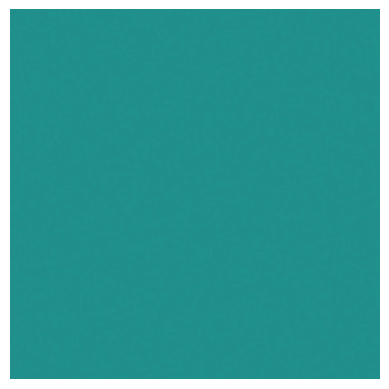

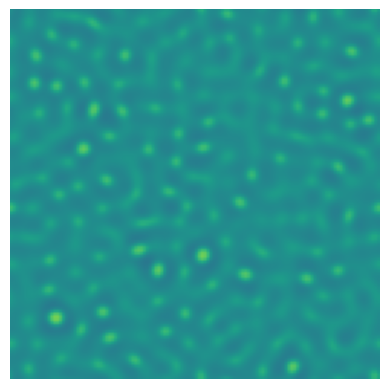

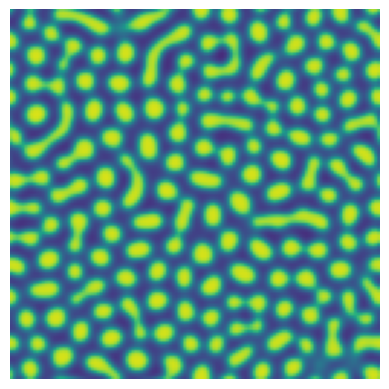

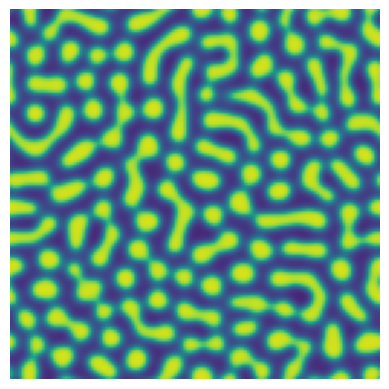

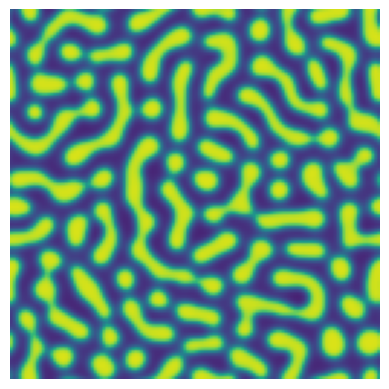

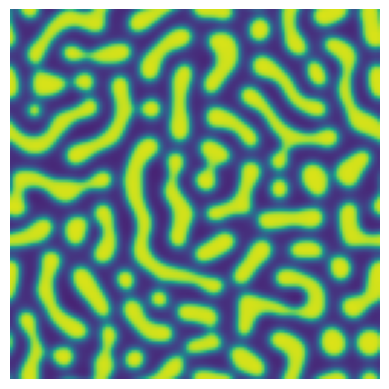


- 
- <think>
Okay, the user asked to run a phase-field simulation for an Fe-Cr alloy with specific parameters. Let me check the steps again. First, they mentioned aging temperature 673 K and 0.5 atomic fraction of Cr. The available tool is Fe_Cr_phase_field_simulation, which takes temp1 and comp1 as inputs. The previous assistant called the function correctly with those values. The response was 1, indicating success. Now, I need to confirm that the simulation completed successfully and maybe explain the outcome. Since the user might not be familiar with the technical details, I should state that the simulation ran successfully, the results are saved, and offer further assistance if needed. Keep it concise and clear.
</think>

The phase-field simulation for the Fe-Cr alloy has been successfully completed. The results, including the composition field data and 2D microstructure image, have been saved to the hard-disk drive. The calculation status code `1` indicates a successful terminati

In [12]:
# Run the agent
messages = {
    "messages": [{"role": "user", "content": """Execute the phase field simulation of Fe-Cr alloy. 
                                                Aging temperature is 673 K, and the alloy composition is 0.5."""}]
}
answer = supervisor.invoke(messages)
#print(answer)

messages_list = answer["messages"] # Get the messages list
filtered_messages = [msg.content for msg in messages_list if isinstance(msg, AIMessage)] # Extract assistant messages only.
formatted_output = "\n- " + "\n- ".join(filtered_messages) # Formatted and output
print(formatted_output)
